In [1]:
import h5py
import torch
import os
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from torch.utils.data.dataset import Dataset
import numpy as np
import setting_2 as setting
import time
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import ComFunction as cf
import math
import spectral
import cv2

from vit_pytorch import ViT

In [2]:
model_name='model_time_2023_01_04_17_56'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type=='cuda':
#     dtype = torch.float32
#     torch.set_default_tensor_type(torch.cuda.FloatTensor)
    dtype = torch.float64
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)
else:
#     dtype = torch.float32
#     torch.set_default_tensor_type(torch.FloatTensor)
    dtype = torch.float64
    torch.set_default_tensor_type(torch.DoubleTensor)
print(device.type)

cuda


In [4]:
class HyperData(Dataset):
    def __init__(self, data, labels, position, transfor):
        self.data = data
        self.transformer = transfor
        self.labels = labels
        self.position = position
        

    def __getitem__(self, index):
        img = self.data[index,:,:]
        label = self.labels[index]
        position = self.position[index,:]
        return img, label, position

    def __len__(self):
        return len(self.labels)

    def __labels__(self):
        return self.labels

In [5]:
def gain_neighborhood_band(x_train, band, band_patch, patch=5):
    nn = band_patch // 2
    pp = (patch*patch) // 2
    x_train_reshape = x_train.reshape(x_train.shape[0], patch*patch, band)
    x_train_band = np.zeros((x_train.shape[0], patch*patch*band_patch, band),dtype=float)
    # 中心区域
    x_train_band[:,nn*patch*patch:(nn+1)*patch*patch,:] = x_train_reshape
    #左边镜像
    for i in range(nn):
        if pp > 0:
            x_train_band[:,i*patch*patch:(i+1)*patch*patch,:i+1] = x_train_reshape[:,:,band-i-1:]
            x_train_band[:,i*patch*patch:(i+1)*patch*patch,i+1:] = x_train_reshape[:,:,:band-i-1]
        else:
            x_train_band[:,i:(i+1),:(nn-i)] = x_train_reshape[:,0:1,(band-nn+i):]
            x_train_band[:,i:(i+1),(nn-i):] = x_train_reshape[:,0:1,:(band-nn+i)]
    #右边镜像
    for i in range(nn):
        if pp > 0:
            x_train_band[:,(nn+i+1)*patch*patch:(nn+i+2)*patch*patch,:band-i-1] = x_train_reshape[:,:,i+1:]
            x_train_band[:,(nn+i+1)*patch*patch:(nn+i+2)*patch*patch,band-i-1:] = x_train_reshape[:,:,:i+1]
        else:
            x_train_band[:,(nn+1+i):(nn+2+i),(band-i-1):] = x_train_reshape[:,0:1,:(i+1)]
            x_train_band[:,(nn+1+i):(nn+2+i),:(band-i-1)] = x_train_reshape[:,0:1,(i+1):]
    return x_train_band

In [6]:
a=np.array([[0,0,0,],
[0.996108949416342,0.992202639810788,0.535164415960937],
[0.996108949416342,0.00781261921110857,0.980483710994125],
[0.996108949416342,0.347661554894331,0.00390630960555428],
[0.719531548027771,0.996108949416342,0.519539177538720],
[0.0117189288166629,0.109376668955520,0.941420614938582],
[0.347661554894331,0.00390630960555428,0.996108949416342],
[0.0117189288166629,0.667978942549783,0.996108949416342],
[0.0468757152666514,0.996108949416342,0.0273441672388800],
[0.671885252155337,0.683604180972000,0.328130006866560],
[0.625009536888685,0.304692149233234,0.617196917677577],
[0.597924773022049,0.677821011673152,1],
[0.234378576333257,0.355474174105440,0.437506675822080],
[0.406256198977646,0.750011444266423,0.246097505149920],
[0.542977035172045,0.269535362783246,0.179690241855497],
[0.964850843060960,0.896108949416342,0.671885252155337],
[0.992202639810788,0.996108949416342,0.0117189288166629]]
)
color_map=255*a

In [7]:
EPOCH=setting.EPOCH
BATCH_SIZE=setting.BATCH_SIZE
LR=setting.LR

In [8]:
net=ViT(
    image_size = setting.PATCH_SIZE,
    near_band = setting.band_patches,
    num_patches = setting.band,
    num_classes = setting.num_class,
    dim =64,
    depth =2,
    heads = 4,
    mlp_dim =6,
    dropout = 0.1,
    emb_dropout = 0.1,
    mode = setting.mode
).to(device)

best_model_name='./model/model_best/'+model_name+'.pth'
model = torch.load(best_model_name)
# final_model_name='./model/'+model_name+'.pth'
# model = torch.load(final_model_name)

net.load_state_dict(model['net'])

<All keys matched successfully>

预测23

In [9]:
no=setting.test_no
print(no)

5


In [10]:
test_filename = './sample/Test_'+str(no)+'_23'+ '_'+str(setting.PATCH_SIZE)+ '_'+ str(setting.DTYPE)+'.h5'
with h5py.File(test_filename,'r') as readfile:
    test=readfile['test_patch'][:]
    test_labels=readfile['test_labels'][:]
    test_position=readfile['test_position'][:]
print('test size:', test.shape)
print('test_labels size:', test_labels.shape)
print('test_position size:', test_position.shape)


# test_max=np.max(np.abs(test))
# print('test max:',test_max)
# stest=stest/stest_max
# print('test label name:',np.unique(test_labels))

test size: (47013, 7, 7, 204)
test_labels size: (47013,)
test_position size: (47013, 2)


In [11]:
test = gain_neighborhood_band(test, setting.band, setting.band_patches, setting.PATCH_SIZE)
print(test.shape)
test =test.transpose(0,2,1)
print(test.shape)

(47013, 343, 204)
(47013, 204, 343)


In [12]:
test_set=HyperData(test, test_labels, test_position,None)
testloader= Data.DataLoader(dataset=test_set,batch_size=BATCH_SIZE,shuffle=False, num_workers=0)

In [13]:
net.eval()
predict_testlabels=[]
testlabels=[]
pre_testposition=[]
t1=time.time()
with torch.no_grad():
    for tsdata in testloader:
        tsinputs, tslabels, tsposition = tsdata
        tsinputs = tsinputs.to(device)
        tslabels = tslabels.to(device)
        tsoutputs = net(tsinputs)
        _, tspredicted = torch.max(F.softmax(tsoutputs), 1)
        predict_testlabels.extend(tspredicted)
        testlabels.extend(tslabels)
        pre_testposition.extend(tsposition)
    print('predict testing set finished')
t2=time.time()
print('predict test time:',t2-t1)



C:\Users\h'p\AppData\Local\Temp\ipykernel_14232\128841729.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, tspredicted = torch.max(F.softmax(tsoutputs), 1)


predict testing set finished
predict test time: 48.59852981567383


In [14]:
predict_testlabels=torch.tensor(predict_testlabels, device='cpu')
testlabels=torch.tensor(testlabels,device='cpu')
# print('predict label class name:',np.unique(predict_testlabels))
oa_test, aa_test, kappa_test, acc_test,cm=cf.eval_results_own(predict_testlabels,testlabels,2)
print('OA_test:',oa_test, '\nAA_test:', aa_test, '\nkappa_test:', kappa_test, '\nacc_test:', acc_test)
print('Confusion matrix：',cm)

OA_test: 0.9765596749835151 
AA_test: 0.9766594891035181 
kappa_test: 0.9395745768601891 
acc_test: [0.97645374 0.97686524]
Confusion matrix： [[34088.   280.]
 [  822. 11823.]]


In [15]:
cm[0,1]

280.0

In [16]:
print('predict label class name:',np.unique(predict_testlabels))

predict label class name: [0 1]


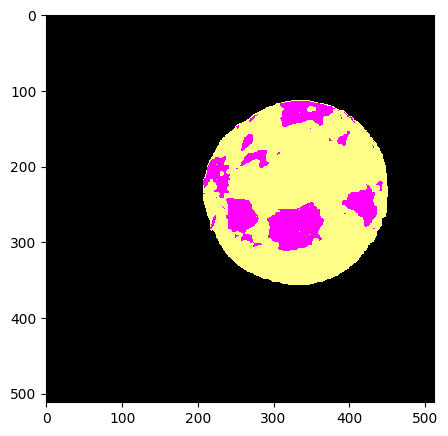

In [17]:
label_file='Label_23'
label_map = cv2.imread(os.path.join(setting.test_label_path, label_file + '.png'), cv2.IMREAD_GRAYSCALE)
label_image = spectral.imshow(classes = label_map,figsize =(5,10),colors=color_map)

In [18]:
[h,w]=label_map.shape
test_map=np.zeros([h,w])
pre_map=np.zeros([h,w])

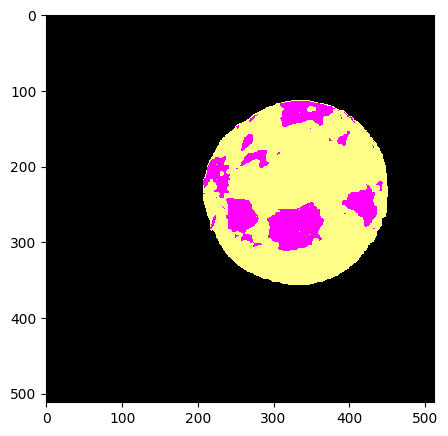

In [19]:
for i in range(len(test_labels)):
    [x,y]=test_position[i,:]
    test_map[x,y]=test_labels[i]+1
    
test_image = spectral.imshow(classes = test_map.astype(int),figsize =(5,10),colors=color_map)

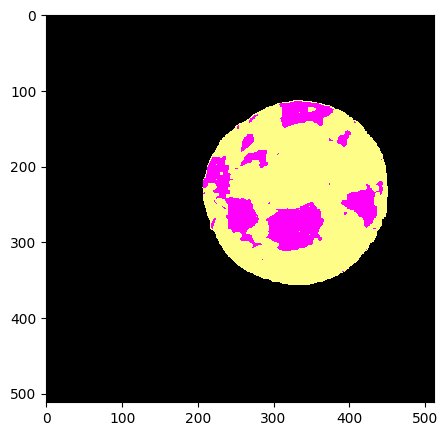

In [20]:
for i in range(len(predict_testlabels)):
    [x,y]=pre_testposition[i]
    pre_map[x,y]=predict_testlabels[i]+1
    
pre_image = spectral.imshow(classes = pre_map.astype(int),figsize =(5,10),colors=color_map)

In [21]:
img_path='./result_image/'+model_name
print(img_path)
cf.mkdir_single(img_path)
img_name=img_path+'/'+label_file+'.png'
print(img_name)
cv2.imwrite(img_name,pre_map.astype(int))

./result_image/model_time_2023_01_04_17_56
目录已存在：model_time_2023_01_04_17_56
./result_image/model_time_2023_01_04_17_56/Label_23.png


True

In [22]:
# I=cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
# I_image = spectral.imshow(classes = I.astype(int),figsize =(5,10),colors=color_map)

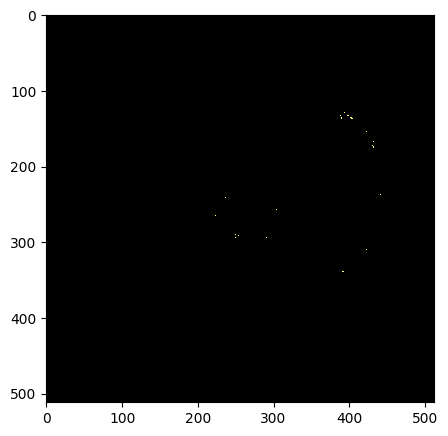

In [23]:
ERR1=np.where(pre_map!=test_map,1,0)
err_image_1 = spectral.imshow(classes = ERR1.astype(int),figsize =(5,10),colors=color_map)

预测25

In [24]:
test_filename = './sample/Test_'+str(no)+'_25'+ '_'+str(setting.PATCH_SIZE)+'_'+ str(setting.DTYPE)+'.h5'
with h5py.File(test_filename,'r') as readfile:
    test=readfile['test_patch'][:]
    test_labels=readfile['test_labels'][:]
    test_position=readfile['test_position'][:]
print('test size:', test.shape)
print('test_labels size:', test_labels.shape)
print('test_position size:', test_position.shape)


# test_max=np.max(np.abs(test))
# print('test max:',test_max)
# stest=stest/stest_max
# print('test label name:',np.unique(test_labels))

test = gain_neighborhood_band(test, setting.band, setting.band_patches, setting.PATCH_SIZE)
print(test.shape)
test =test.transpose(0,2,1)
print(test.shape)

test size: (40180, 7, 7, 204)
test_labels size: (40180,)
test_position size: (40180, 2)
(40180, 343, 204)
(40180, 204, 343)


In [25]:
test_set=HyperData(test, test_labels, test_position,None)
testloader= Data.DataLoader(dataset=test_set,batch_size=BATCH_SIZE,shuffle=False, num_workers=0)

In [26]:
net.eval()
predict_testlabels=[]
testlabels=[]
pre_testposition=[]
t1=time.time()
with torch.no_grad():
    for tsdata in testloader:
        tsinputs, tslabels, tsposition = tsdata
        tsinputs = tsinputs.to(device)
        tslabels = tslabels.to(device)
        tsoutputs = net(tsinputs)
        _, tspredicted = torch.max(F.softmax(tsoutputs), 1)
        predict_testlabels.extend(tspredicted)
        testlabels.extend(tslabels)
        pre_testposition.extend(tsposition)
    print('predict testing set finished')
t2=time.time()
print('predict test time:',t2-t1)
# print('predict label class name:',np.unique(predict_testlabels))

# predict_testlabels=torch.tensor(predict_testlabels, device='cpu')
# testlabels=torch.tensor(testlabels,device='cpu')
# oa_test, aa_test, kappa_test, acc_test=cf.eval_results_own(predict_testlabels,testlabels,2)
# print('OA_test:',oa_test, '\nAA_test:', aa_test, '\nkappa_test:', kappa_test, '\nacc_test:', acc_test)

C:\Users\h'p\AppData\Local\Temp\ipykernel_14232\3006041116.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, tspredicted = torch.max(F.softmax(tsoutputs), 1)


predict testing set finished
predict test time: 49.96900296211243


In [27]:
predict_testlabels=torch.tensor(predict_testlabels, device='cpu')
testlabels=torch.tensor(testlabels,device='cpu')
# print('predict label class name:',np.unique(predict_testlabels))
oa_test, aa_test, kappa_test, acc_test,cm=cf.eval_results_own(predict_testlabels,testlabels,2)
print('OA_test:',oa_test, '\nAA_test:', aa_test, '\nkappa_test:', kappa_test, '\nacc_test:', acc_test)
print('Confusion matrix：',cm)

OA_test: 0.966376306620209 
AA_test: 0.9680257245787643 
kappa_test: 0.9320905008352929 
acc_test: [0.95405574 0.98199571]
Confusion matrix： [[21430.   319.]
 [ 1032. 17399.]]


In [28]:
print('predict label class name:',np.unique(predict_testlabels))

predict label class name: [0 1]


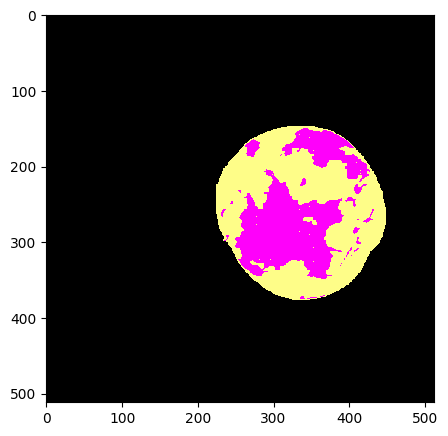

In [29]:
label_file='Label_25'
label_map = cv2.imread(os.path.join(setting.test_label_path, label_file + '.png'), cv2.IMREAD_GRAYSCALE)
label_image = spectral.imshow(classes = label_map,figsize =(5,10),colors=color_map)

In [30]:
[h,w]=label_map.shape
test_map=np.zeros([h,w])
pre_map=np.zeros([h,w])

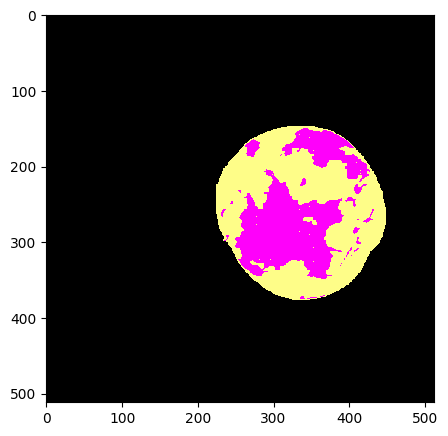

In [31]:
for i in range(len(test_labels)):
    [x,y]=test_position[i,:]
    test_map[x,y]=test_labels[i]+1
    
test_image = spectral.imshow(classes = test_map.astype(int),figsize =(5,10),colors=color_map)

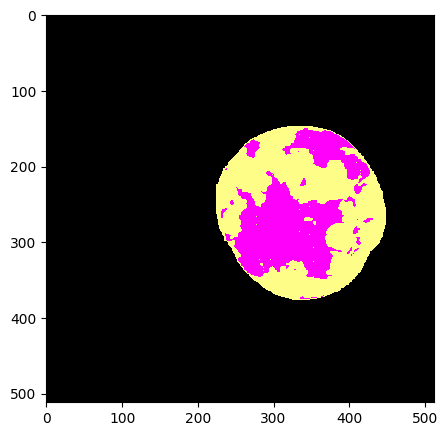

In [32]:
for i in range(len(predict_testlabels)):
    [x,y]=pre_testposition[i]
    pre_map[x,y]=predict_testlabels[i]+1
    
pre_image = spectral.imshow(classes = pre_map.astype(int),figsize =(5,10),colors=color_map)

In [33]:
img_path='./result_image/'+model_name
print(img_path)
cf.mkdir_single(img_path)
img_name=img_path+'/'+label_file+'.png'
print(img_name)
cv2.imwrite(img_name,pre_map.astype(int))

./result_image/model_time_2023_01_04_17_56
目录已存在：model_time_2023_01_04_17_56
./result_image/model_time_2023_01_04_17_56/Label_25.png


True

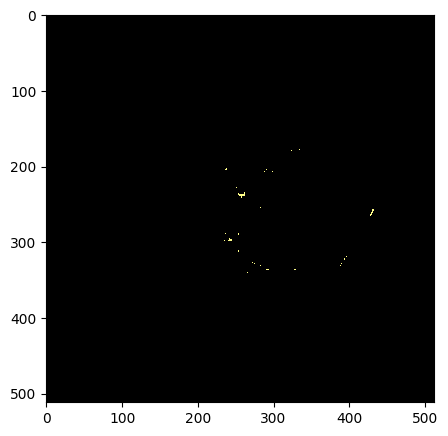

In [34]:
ERR1=np.where(pre_map!=test_map,1,0)
err_image_1 = spectral.imshow(classes = ERR1.astype(int),figsize =(5,10),colors=color_map)

预测27

In [35]:
test_filename = './sample/Test_'+str(no)+'_27'+ '_'+str(setting.PATCH_SIZE)+'_'+ str(setting.DTYPE)+'.h5'
with h5py.File(test_filename,'r') as readfile:
    test=readfile['test_patch'][:]
    test_labels=readfile['test_labels'][:]
    test_position=readfile['test_position'][:]
print('test size:', test.shape)
print('test_labels size:', test_labels.shape)
print('test_position size:', test_position.shape)


# test_max=np.max(np.abs(test))
# print('test max:',test_max)
# stest=stest/stest_max
# print('test label name:',np.unique(test_labels))

test = gain_neighborhood_band(test, setting.band, setting.band_patches, setting.PATCH_SIZE)
print(test.shape)
test =test.transpose(0,2,1)
print(test.shape)

test size: (45596, 7, 7, 204)
test_labels size: (45596,)
test_position size: (45596, 2)
(45596, 343, 204)
(45596, 204, 343)


In [36]:
test_set=HyperData(test, test_labels, test_position,None)
testloader= Data.DataLoader(dataset=test_set,batch_size=BATCH_SIZE,shuffle=False, num_workers=0)

In [37]:
net.eval()
predict_testlabels=[]
testlabels=[]
pre_testposition=[]
t1=time.time()
with torch.no_grad():
    for tsdata in testloader:
        tsinputs, tslabels, tsposition = tsdata
        tsinputs = tsinputs.to(device)
        tslabels = tslabels.to(device)
        tsoutputs = net(tsinputs)
        _, tspredicted = torch.max(F.softmax(tsoutputs), 1)
        predict_testlabels.extend(tspredicted)
        testlabels.extend(tslabels)
        pre_testposition.extend(tsposition)
    print('predict testing set finished')
t2=time.time()
print('predict test time:',t2-t1)
# print('predict label class name:',np.unique(predict_testlabels))

# predict_testlabels=torch.tensor(predict_testlabels, device='cpu')
# testlabels=torch.tensor(testlabels,device='cpu')
# oa_test, aa_test, kappa_test, acc_test=cf.eval_results_own(predict_testlabels,testlabels,2)
# print('OA_test:',oa_test, '\nAA_test:', aa_test, '\nkappa_test:', kappa_test, '\nacc_test:', acc_test)

C:\Users\h'p\AppData\Local\Temp\ipykernel_14232\3006041116.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, tspredicted = torch.max(F.softmax(tsoutputs), 1)


predict testing set finished
predict test time: 62.46416926383972


In [38]:
predict_testlabels=torch.tensor(predict_testlabels, device='cpu')
testlabels=torch.tensor(testlabels,device='cpu')
# print('predict label class name:',np.unique(predict_testlabels))
oa_test, aa_test, kappa_test, acc_test,cm=cf.eval_results_own(predict_testlabels,testlabels,2)
print('OA_test:',oa_test, '\nAA_test:', aa_test, '\nkappa_test:', kappa_test, '\nacc_test:', acc_test)
print('Confusion matrix：',cm)

OA_test: 0.952824809193789 
AA_test: 0.9374519995287648 
kappa_test: 0.8924353501079958 
acc_test: [0.89007207 0.98483193]
Confusion matrix： [[13708.   458.]
 [ 1693. 29737.]]


In [39]:
print('predict label class name:',np.unique(predict_testlabels))

predict label class name: [0 1]


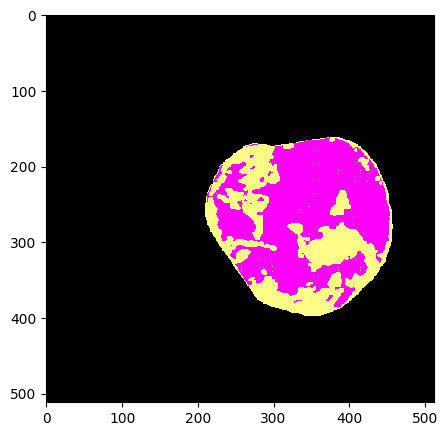

In [40]:
label_file='Label_27'
label_map = cv2.imread(os.path.join(setting.test_label_path, label_file + '.png'), cv2.IMREAD_GRAYSCALE)
label_image = spectral.imshow(classes = label_map,figsize =(5,10),colors=color_map)

In [41]:
[h,w]=label_map.shape
test_map=np.zeros([h,w])
pre_map=np.zeros([h,w])

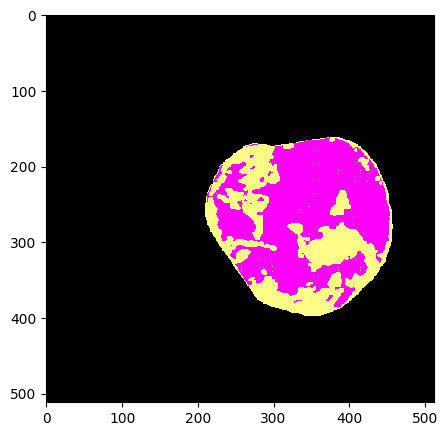

In [42]:
for i in range(len(test_labels)):
    [x,y]=test_position[i,:]
    test_map[x,y]=test_labels[i]+1
    
test_image = spectral.imshow(classes = test_map.astype(int),figsize =(5,10),colors=color_map)

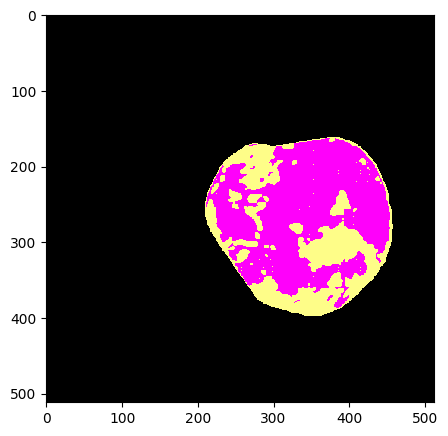

In [43]:
for i in range(len(predict_testlabels)):
    [x,y]=pre_testposition[i]
    pre_map[x,y]=predict_testlabels[i]+1
    
pre_image = spectral.imshow(classes = pre_map.astype(int),figsize =(5,10),colors=color_map)

In [44]:
img_path='./result_image/'+model_name
print(img_path)
cf.mkdir_single(img_path)
img_name=img_path+'/'+label_file+'.png'
print(img_name)
cv2.imwrite(img_name,pre_map.astype(int))

./result_image/model_time_2023_01_04_17_56
目录已存在：model_time_2023_01_04_17_56
./result_image/model_time_2023_01_04_17_56/Label_27.png


True

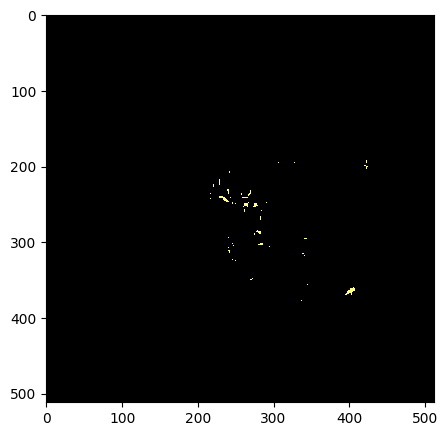

In [45]:
ERR1=np.where(pre_map!=test_map,1,0)
err_image_1 = spectral.imshow(classes = ERR1.astype(int),figsize =(5,10),colors=color_map)

预测30

In [46]:
test_filename = './sample/Test_'+str(no)+'_30'+ '_'+str(setting.PATCH_SIZE)+'_'+ str(setting.DTYPE)+'.h5'
with h5py.File(test_filename,'r') as readfile:
    test=readfile['test_patch'][:]
    test_labels=readfile['test_labels'][:]
    test_position=readfile['test_position'][:]
print('test size:', test.shape)
print('test_labels size:', test_labels.shape)
print('test_position size:', test_position.shape)


# test_max=np.max(np.abs(test))
# print('test max:',test_max)
# stest=stest/stest_max
# print('test label name:',np.unique(test_labels))

test= gain_neighborhood_band(test, setting.band, setting.band_patches, setting.PATCH_SIZE)
print(test.shape)
test =test.transpose(0,2,1)
print(test.shape)

test size: (45855, 7, 7, 204)
test_labels size: (45855,)
test_position size: (45855, 2)
(45855, 343, 204)
(45855, 204, 343)


In [47]:
test_set=HyperData(test, test_labels, test_position,None)
testloader= Data.DataLoader(dataset=test_set,batch_size=BATCH_SIZE,shuffle=False, num_workers=0)

In [48]:
net.eval()
predict_testlabels=[]
testlabels=[]
pre_testposition=[]
t1=time.time()
with torch.no_grad():
    for tsdata in testloader:
        tsinputs, tslabels, tsposition = tsdata
        tsinputs = tsinputs.to(device)
        tslabels = tslabels.to(device)
        tsoutputs = net(tsinputs)
        _, tspredicted = torch.max(F.softmax(tsoutputs), 1)
        predict_testlabels.extend(tspredicted)
        testlabels.extend(tslabels)
        pre_testposition.extend(tsposition)
    print('predict testing set finished')
t2=time.time()
print('predict test time:',t2-t1)
# print('predict label class name:',np.unique(predict_testlabels))

# predict_testlabels=torch.tensor(predict_testlabels, device='cpu')
# testlabels=torch.tensor(testlabels,device='cpu')
# oa_test, aa_test, kappa_test, acc_test=cf.eval_results_own(predict_testlabels,testlabels,2)
# print('OA_test:',oa_test, '\nAA_test:', aa_test, '\nkappa_test:', kappa_test, '\nacc_test:', acc_test)

C:\Users\h'p\AppData\Local\Temp\ipykernel_14232\3006041116.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, tspredicted = torch.max(F.softmax(tsoutputs), 1)


predict testing set finished
predict test time: 58.38625121116638


In [49]:
predict_testlabels=torch.tensor(predict_testlabels, device='cpu')
testlabels=torch.tensor(testlabels,device='cpu')
# print('predict label class name:',np.unique(predict_testlabels))
oa_test, aa_test, kappa_test, acc_test,cm=cf.eval_results_own(predict_testlabels,testlabels,2)
print('OA_test:',oa_test, '\nAA_test:', aa_test, '\nkappa_test:', kappa_test, '\nacc_test:', acc_test)
print('Confusion matrix：',cm)

OA_test: 0.9728491985606804 
AA_test: 0.9656940484645362 
kappa_test: 0.9394876365665387 
acc_test: [0.9889289  0.94245919]
Confusion matrix： [[29656.   913.]
 [  332. 14954.]]


In [50]:
print('predict label class name:',np.unique(predict_testlabels))

predict label class name: [0 1]


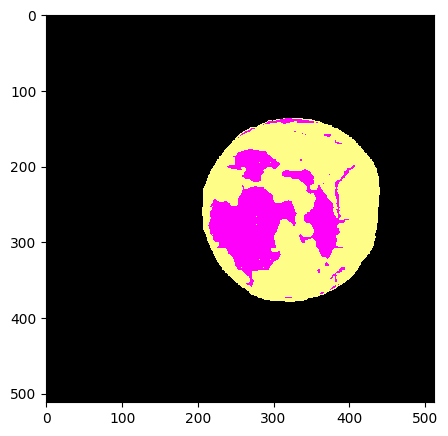

In [51]:
label_file='Label_30'
label_map = cv2.imread(os.path.join(setting.test_label_path, label_file + '.png'), cv2.IMREAD_GRAYSCALE)
label_image = spectral.imshow(classes = label_map,figsize =(5,10),colors=color_map)

In [52]:
[h,w]=label_map.shape
test_map=np.zeros([h,w])
pre_map=np.zeros([h,w])

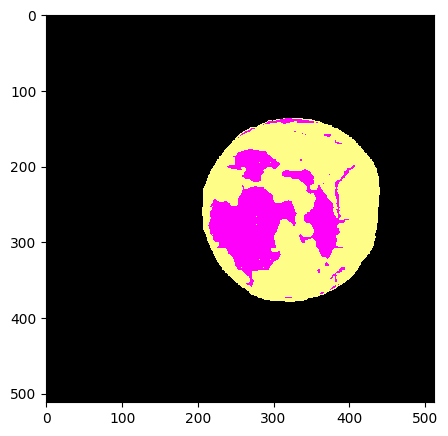

In [53]:
for i in range(len(test_labels)):
    [x,y]=test_position[i,:]
    test_map[x,y]=test_labels[i]+1
    
test_image = spectral.imshow(classes = test_map.astype(int),figsize =(5,10),colors=color_map)

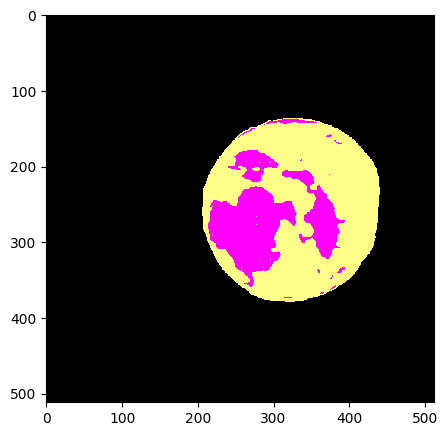

In [54]:
for i in range(len(predict_testlabels)):
    [x,y]=pre_testposition[i]
    pre_map[x,y]=predict_testlabels[i]+1
    
pre_image = spectral.imshow(classes = pre_map.astype(int),figsize =(5,10),colors=color_map)

In [55]:
img_path='./result_image/'+model_name
print(img_path)
cf.mkdir_single(img_path)
img_name=img_path+'/'+label_file+'.png'
print(img_name)
cv2.imwrite(img_name,pre_map.astype(int))

./result_image/model_time_2023_01_04_17_56
目录已存在：model_time_2023_01_04_17_56
./result_image/model_time_2023_01_04_17_56/Label_30.png


True

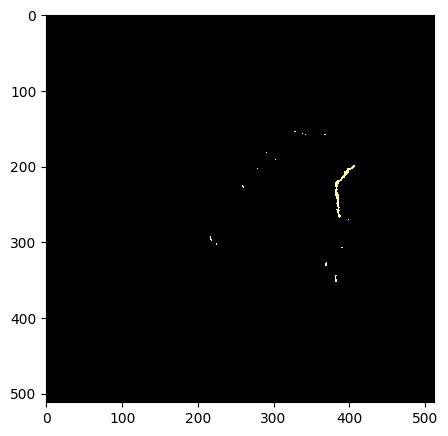

In [56]:
ERR1=np.where(pre_map!=test_map,1,0)
err_image_1 = spectral.imshow(classes = ERR1.astype(int),figsize =(5,10),colors=color_map)

预测33

In [57]:
test_filename = './sample/Test_'+str(no)+'_33'+ '_'+str(setting.PATCH_SIZE)+'_'+ str(setting.DTYPE)+'.h5'
with h5py.File(test_filename,'r') as readfile:
    test=readfile['test_patch'][:]
    test_labels=readfile['test_labels'][:]
    test_position=readfile['test_position'][:]
print('test size:', test.shape)
print('test_labels size:', test_labels.shape)
print('test_position size:', test_position.shape)


# test_max=np.max(np.abs(test))
# print('test max:',test_max)
# stest=stest/stest_max
# print('test label name:',np.unique(test_labels))

test = gain_neighborhood_band(test, setting.band, setting.band_patches, setting.PATCH_SIZE)
print(test.shape)
test =test.transpose(0,2,1)
print(test.shape)

test size: (40161, 7, 7, 204)
test_labels size: (40161,)
test_position size: (40161, 2)
(40161, 343, 204)
(40161, 204, 343)


In [58]:
test_set=HyperData(test, test_labels, test_position,None)
testloader= Data.DataLoader(dataset=test_set,batch_size=BATCH_SIZE,shuffle=False, num_workers=0)

In [59]:
net.eval()
predict_testlabels=[]
testlabels=[]
pre_testposition=[]
t1=time.time()
with torch.no_grad():
    for tsdata in testloader:
        tsinputs, tslabels, tsposition = tsdata
        tsinputs = tsinputs.to(device)
        tslabels = tslabels.to(device)
        tsoutputs = net(tsinputs)
        _, tspredicted = torch.max(F.softmax(tsoutputs), 1)
        predict_testlabels.extend(tspredicted)
        testlabels.extend(tslabels)
        pre_testposition.extend(tsposition)
    print('predict testing set finished')
t2=time.time()
print('predict test time:',t2-t1)
# print('predict label class name:',np.unique(predict_testlabels))

# predict_testlabels=torch.tensor(predict_testlabels, device='cpu')
# testlabels=torch.tensor(testlabels,device='cpu')
# oa_test, aa_test, kappa_test, acc_test=cf.eval_results_own(predict_testlabels,testlabels,2)
# print('OA_test:',oa_test, '\nAA_test:', aa_test, '\nkappa_test:', kappa_test, '\nacc_test:', acc_test)

C:\Users\h'p\AppData\Local\Temp\ipykernel_14232\3006041116.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, tspredicted = torch.max(F.softmax(tsoutputs), 1)


predict testing set finished
predict test time: 40.35819935798645


In [60]:
predict_testlabels=torch.tensor(predict_testlabels, device='cpu')
testlabels=torch.tensor(testlabels,device='cpu')
# print('predict label class name:',np.unique(predict_testlabels))
oa_test, aa_test, kappa_test, acc_test,cm=cf.eval_results_own(predict_testlabels,testlabels,2)
print('OA_test:',oa_test, '\nAA_test:', aa_test, '\nkappa_test:', kappa_test, '\nacc_test:', acc_test)
print('Confusion matrix：',cm)

OA_test: 0.9539852095316351 
AA_test: 0.9595507234773317 
kappa_test: 0.8996045485973171 
acc_test: [0.94219021 0.97691124]
Confusion matrix： [[24985.   315.]
 [ 1533. 13328.]]


In [61]:
print('predict label class name:',np.unique(predict_testlabels))

predict label class name: [0 1]


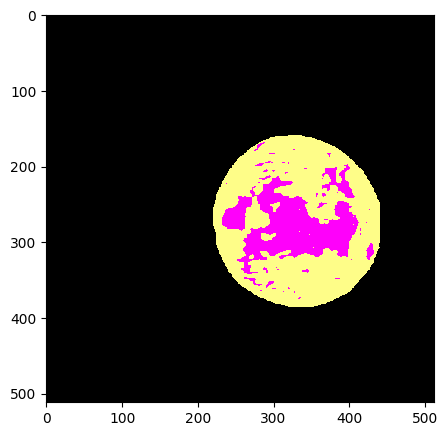

In [62]:
label_file='Label_33'
label_map = cv2.imread(os.path.join(setting.test_label_path, label_file + '.png'), cv2.IMREAD_GRAYSCALE)
label_image = spectral.imshow(classes = label_map,figsize =(5,10),colors=color_map)

In [63]:
[h,w]=label_map.shape
test_map=np.zeros([h,w])
pre_map=np.zeros([h,w])

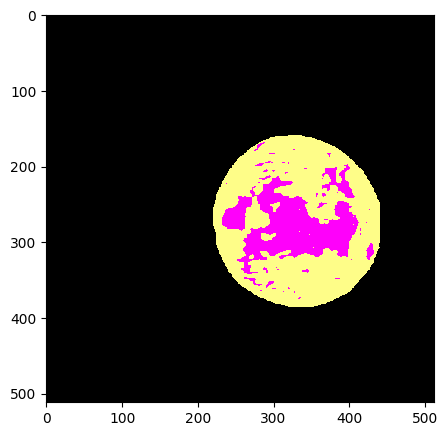

In [64]:
for i in range(len(test_labels)):
    [x,y]=test_position[i,:]
    test_map[x,y]=test_labels[i]+1
    
test_image = spectral.imshow(classes = test_map.astype(int),figsize =(5,10),colors=color_map)

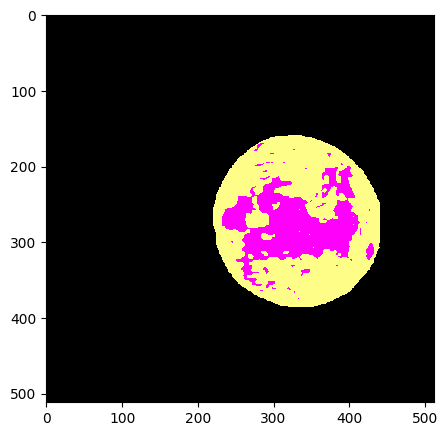

In [65]:
for i in range(len(predict_testlabels)):
    [x,y]=pre_testposition[i]
    pre_map[x,y]=predict_testlabels[i]+1
    
pre_image = spectral.imshow(classes = pre_map.astype(int),figsize =(5,10),colors=color_map)

In [66]:
img_path='./result_image/'+model_name
print(img_path)
cf.mkdir_single(img_path)
img_name=img_path+'/'+label_file+'.png'
print(img_name)
cv2.imwrite(img_name,pre_map.astype(int))

./result_image/model_time_2023_01_04_17_56
目录已存在：model_time_2023_01_04_17_56
./result_image/model_time_2023_01_04_17_56/Label_33.png


True

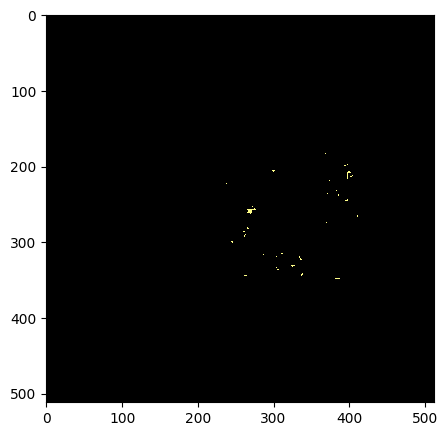

In [67]:
ERR1=np.where(pre_map!=test_map,1,0)
err_image_1 = spectral.imshow(classes = ERR1.astype(int),figsize =(5,10),colors=color_map)

预测35

In [68]:
test_filename = './sample/Test_'+str(no)+'_35'+ '_'+str(setting.PATCH_SIZE)+'_'+ str(setting.DTYPE)+'.h5'
with h5py.File(test_filename,'r') as readfile:
    test=readfile['test_patch'][:]
    test_labels=readfile['test_labels'][:]
    test_position=readfile['test_position'][:]
print('test size:', test.shape)
print('test_labels size:', test_labels.shape)
print('test_position size:', test_position.shape)


# test_max=np.max(np.abs(test))
# print('test max:',test_max)
# stest=stest/stest_max
# print('test label name:',np.unique(test_labels))

test = gain_neighborhood_band(test, setting.band, setting.band_patches, setting.PATCH_SIZE)
print(test.shape)
test =test.transpose(0,2,1)
print(test.shape)

test size: (36524, 7, 7, 204)
test_labels size: (36524,)
test_position size: (36524, 2)
(36524, 343, 204)
(36524, 204, 343)


In [69]:
test_set=HyperData(test, test_labels, test_position,None)
testloader= Data.DataLoader(dataset=test_set,batch_size=BATCH_SIZE,shuffle=False, num_workers=0)

In [70]:
net.eval()
predict_testlabels=[]
testlabels=[]
pre_testposition=[]
t1=time.time()
with torch.no_grad():
    for tsdata in testloader:
        tsinputs, tslabels, tsposition = tsdata
        tsinputs = tsinputs.to(device)
        tslabels = tslabels.to(device)
        tsoutputs = net(tsinputs)
        _, tspredicted = torch.max(F.softmax(tsoutputs), 1)
        predict_testlabels.extend(tspredicted)
        testlabels.extend(tslabels)
        pre_testposition.extend(tsposition)
    print('predict testing set finished')
t2=time.time()
print('predict test time:',t2-t1)
# print('predict label class name:',np.unique(predict_testlabels))

# predict_testlabels=torch.tensor(predict_testlabels, device='cpu')
# testlabels=torch.tensor(testlabels,device='cpu')
# oa_test, aa_test, kappa_test, acc_test=cf.eval_results_own(predict_testlabels,testlabels,2)
# print('OA_test:',oa_test, '\nAA_test:', aa_test, '\nkappa_test:', kappa_test, '\nacc_test:', acc_test)

C:\Users\h'p\AppData\Local\Temp\ipykernel_14232\3006041116.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, tspredicted = torch.max(F.softmax(tsoutputs), 1)


predict testing set finished
predict test time: 34.969929695129395


In [71]:
predict_testlabels=torch.tensor(predict_testlabels, device='cpu')
testlabels=torch.tensor(testlabels,device='cpu')
# print('predict label class name:',np.unique(predict_testlabels))
oa_test, aa_test, kappa_test, acc_test,cm=cf.eval_results_own(predict_testlabels,testlabels,2)
print('OA_test:',oa_test, '\nAA_test:', aa_test, '\nkappa_test:', kappa_test, '\nacc_test:', acc_test)
print('Confusion matrix：',cm)

OA_test: 0.9597524915124301 
AA_test: 0.9588179860390047 
kappa_test: 0.9136005978878251 
acc_test: [0.9622902  0.95534577]
Confusion matrix： [[22303.   596.]
 [  874. 12751.]]


In [72]:
print('predict label class name:',np.unique(predict_testlabels))

predict label class name: [0 1]


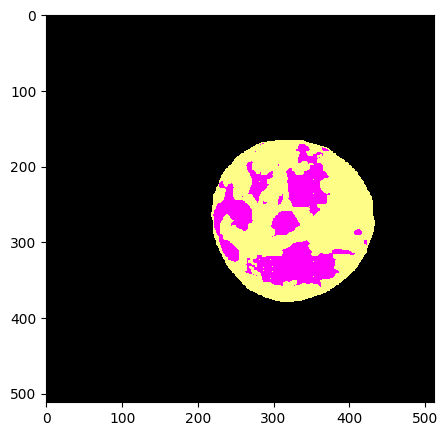

In [73]:
label_file='Label_35'
label_map = cv2.imread(os.path.join(setting.test_label_path, label_file + '.png'), cv2.IMREAD_GRAYSCALE)
label_image = spectral.imshow(classes = label_map,figsize =(5,10),colors=color_map)

In [74]:
[h,w]=label_map.shape
test_map=np.zeros([h,w])
pre_map=np.zeros([h,w])

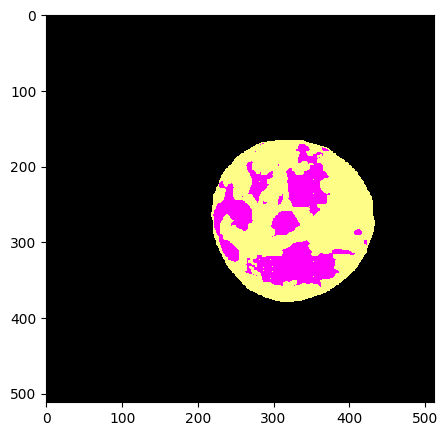

In [75]:
for i in range(len(test_labels)):
    [x,y]=test_position[i,:]
    test_map[x,y]=test_labels[i]+1
    
test_image = spectral.imshow(classes = test_map.astype(int),figsize =(5,10),colors=color_map)

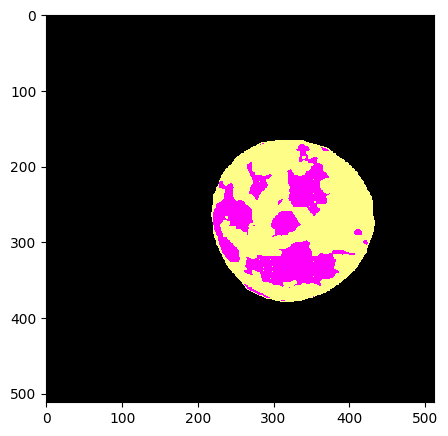

In [76]:
for i in range(len(predict_testlabels)):
    [x,y]=pre_testposition[i]
    pre_map[x,y]=predict_testlabels[i]+1
    
pre_image = spectral.imshow(classes = pre_map.astype(int),figsize =(5,10),colors=color_map)

In [77]:
img_path='./result_image/'+model_name
print(img_path)
cf.mkdir_single(img_path)
img_name=img_path+'/'+label_file+'.png'
print(img_name)
cv2.imwrite(img_name,pre_map.astype(int))

./result_image/model_time_2023_01_04_17_56
目录已存在：model_time_2023_01_04_17_56
./result_image/model_time_2023_01_04_17_56/Label_35.png


True

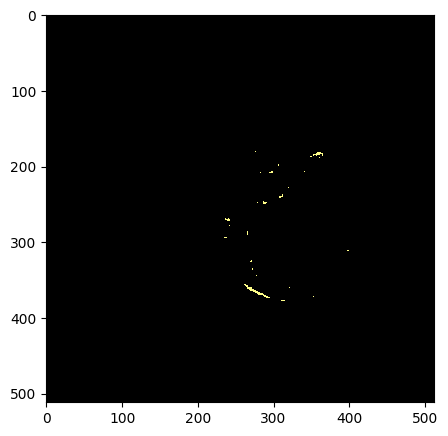

In [78]:
ERR1=np.where(pre_map!=test_map,1,0)
err_image_1 = spectral.imshow(classes = ERR1.astype(int),figsize =(5,10),colors=color_map)


预测36

In [79]:
test_filename = './sample/Test_'+str(no)+'_36'+ '_'+str(setting.PATCH_SIZE)+'_'+ str(setting.DTYPE)+'.h5'
with h5py.File(test_filename,'r') as readfile:
    test=readfile['test_patch'][:]
    test_labels=readfile['test_labels'][:]
    test_position=readfile['test_position'][:]
print('test size:', test.shape)
print('test_labels size:', test_labels.shape)
print('test_position size:', test_position.shape)


# test_max=np.max(np.abs(test))
# print('test max:',test_max)
# stest=stest/stest_max
# print('test label name:',np.unique(test_labels))

test = gain_neighborhood_band(test, setting.band, setting.band_patches, setting.PATCH_SIZE)
print(test.shape)
test =test.transpose(0,2,1)
print(test.shape)

test size: (46146, 7, 7, 204)
test_labels size: (46146,)
test_position size: (46146, 2)
(46146, 343, 204)
(46146, 204, 343)


In [80]:
test_set=HyperData(test, test_labels, test_position,None)
testloader= Data.DataLoader(dataset=test_set,batch_size=BATCH_SIZE,shuffle=False, num_workers=0)

In [81]:
net.eval()
predict_testlabels=[]
testlabels=[]
pre_testposition=[]
t1=time.time()
with torch.no_grad():
    for tsdata in testloader:
        tsinputs, tslabels, tsposition = tsdata
        tsinputs = tsinputs.to(device)
        tslabels = tslabels.to(device)
        tsoutputs = net(tsinputs)
        _, tspredicted = torch.max(F.softmax(tsoutputs), 1)
        predict_testlabels.extend(tspredicted)
        testlabels.extend(tslabels)
        pre_testposition.extend(tsposition)
    print('predict testing set finished')
t2=time.time()
print('predict test time:',t2-t1)
# print('predict label class name:',np.unique(predict_testlabels))

# predict_testlabels=torch.tensor(predict_testlabels, device='cpu')
# testlabels=torch.tensor(testlabels,device='cpu')
# oa_test, aa_test, kappa_test, acc_test=cf.eval_results_own(predict_testlabels,testlabels,2)
# print('OA_test:',oa_test, '\nAA_test:', aa_test, '\nkappa_test:', kappa_test, '\nacc_test:', acc_test)

C:\Users\h'p\AppData\Local\Temp\ipykernel_14232\3006041116.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, tspredicted = torch.max(F.softmax(tsoutputs), 1)


predict testing set finished
predict test time: 59.36593008041382


In [82]:
predict_testlabels=torch.tensor(predict_testlabels, device='cpu')
testlabels=torch.tensor(testlabels,device='cpu')
# print('predict label class name:',np.unique(predict_testlabels))
oa_test, aa_test, kappa_test, acc_test,cm=cf.eval_results_own(predict_testlabels,testlabels,2)
print('OA_test:',oa_test, '\nAA_test:', aa_test, '\nkappa_test:', kappa_test, '\nacc_test:', acc_test)
print('Confusion matrix：',cm)

OA_test: 0.9885147141680752 
AA_test: 0.9809982805891575 
kappa_test: 0.9530713473061537 
acc_test: [0.99147154 0.97052502]
Confusion matrix： [[39294.   192.]
 [  338.  6322.]]


In [83]:
print('predict label class name:',np.unique(predict_testlabels))

predict label class name: [0 1]


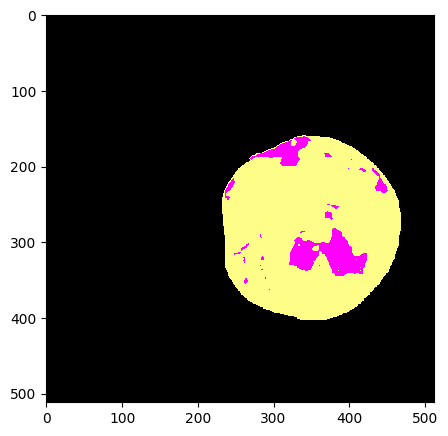

In [84]:
label_file='Label_36'
label_map = cv2.imread(os.path.join(setting.test_label_path, label_file + '.png'), cv2.IMREAD_GRAYSCALE)
label_image = spectral.imshow(classes = label_map,figsize =(5,10),colors=color_map)

In [85]:
[h,w]=label_map.shape
test_map=np.zeros([h,w])
pre_map=np.zeros([h,w])

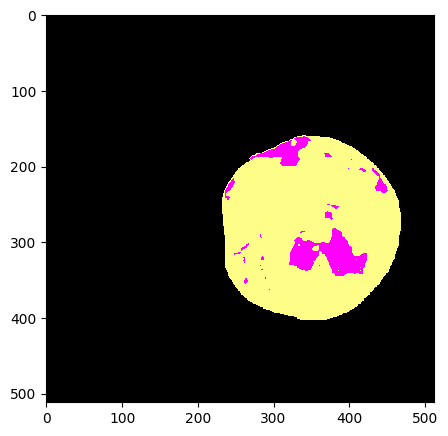

In [86]:
for i in range(len(test_labels)):
    [x,y]=test_position[i,:]
    test_map[x,y]=test_labels[i]+1
    
test_image = spectral.imshow(classes = test_map.astype(int),figsize =(5,10),colors=color_map)

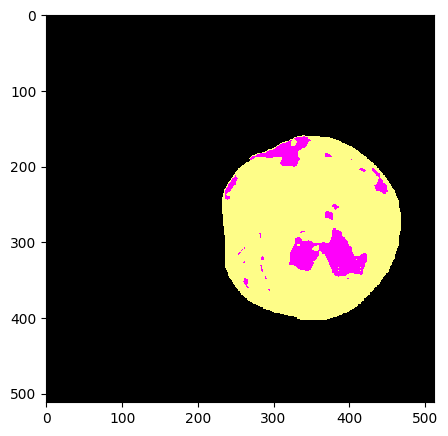

In [87]:
for i in range(len(predict_testlabels)):
    [x,y]=pre_testposition[i]
    pre_map[x,y]=predict_testlabels[i]+1
    
pre_image = spectral.imshow(classes = pre_map.astype(int),figsize =(5,10),colors=color_map)

In [88]:
img_path='./result_image/'+model_name
print(img_path)
cf.mkdir_single(img_path)
img_name=img_path+'/'+label_file+'.png'
print(img_name)
cv2.imwrite(img_name,pre_map.astype(int))

./result_image/model_time_2023_01_04_17_56
目录已存在：model_time_2023_01_04_17_56
./result_image/model_time_2023_01_04_17_56/Label_36.png


True

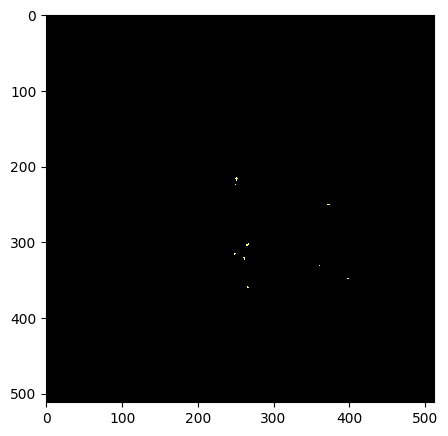

In [89]:
ERR1=np.where(pre_map!=test_map,1,0)
err_image_1 = spectral.imshow(classes = ERR1.astype(int),figsize =(5,10),colors=color_map)